**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
лемматизация + TFIDF + DBSCAN

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

/usr/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

from matplotlib import pyplot as plt

from pymorphy2 import MorphAnalyzer

SKLEARN_VERSION

'0.23.2'

## тексты

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [4]:
data.sample(2)

,text,tag
1270,Пассажирке пришлось сесть за руль автобуса Ecolines Таллин — Рига вместо пьяного водителя\n\n27 ноября 2016 в 16:00\n\nAUTO.TUT.BY\n\nМолодой эстонке Трийн Кибур пришлось взять на себя управление ...,auto
1188,Вице-премьер Калинин: в Минске более 5000 непроданных квартир\n\n30 ноября 2016 в 13:50\n\nREALTY.TUT.BY\n\nСегодня вице-премьер Анатолий Калинин отвечал на вопросы парламентариев. А после — журна...,realty


## токенизация и очистка

In [5]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [6]:
# лемматизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()

# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# NOUN (существительное), VERB (глагол), ADJF (прилагательное)
def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''


def tokenize_normalize(s):
    return [ word_normalizer(w) for w in s.split(' ') if len(w)>1 ]

In [7]:
data['ctext'] = data['text']\
                    .progress_apply(string_normalizer)\
                    .progress_apply(tokenize_normalize)

100%|██████████| 3196/3196 [01:11<00:00, 44.42it/s]


In [8]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

словарь 22123 слов


In [9]:
data['ctext'] = data['ctext'].apply(' '.join)

In [10]:
data.sample(10)

,text,tag,ctext
2023,"Сборная Южной Кореи по скелетону решила бойкотировать чемпионат мира по бобслею и скелетону 2017 года, который пройдет в Сочи. Об этом во вторник, 13 декабря, сообщает южнокорейское агентство «Ёнх...",sport,сборная южный корея скелетон решить чемпионат мир бобслей скелетон год который пройти сочи вторник декабрь сообщать южнокорейский агентство материал тема скелет шкаф сборный латвия бойко...
2106,"12 декабря 2016 в 22.45 (МСК) начнется матч 15 тура чемпионата Испании, в котором Вильярреал на своем поле будет принимать мадридский Атлетико. Эксперт биржи ставок Betfair Джек Ланг делится с нам...",sport,декабрь начаться матч тур чемпионат испания который свой пол быть мадридский эксперт биржа ставка джек делиться свой прогноз матч мадрид мадридский минувший тур чемпионат испания суме...
1616,"МОСКВА, 12 дек — РИА Новости. Российский Центр примирения в Сирии за последние сутки доставил более 78 тонн гуманитарной помощи, сообщил в понедельник на брифинге официальный представитель Минобор...",politics,москва дек риа новость российский центр примирение сирия последний сутки доставить тонна гуманитарный помощь сообщить понедельник брифинг официальный представитель минобороны россия генерал-май...
1411,"Президент России Владимир Путин 15 декабря прибудет в аэропорт префектуры Ямагути на юго-западе японского острова Хонсю, где в городе Нагато проведет встречу с премьер-министром страны Синдзо Абэ....",politics,президент россия владимир путин декабрь прибыть аэропорт префектура ямагути юго-запад японский остров хонсю город провести встреча премьер-министр страна говориться программа визит президен...
1091,"Волейболисты ""Шахтера"" в первом матче 1/16 финала Кубка вызова проиграли российскому ""Факелу""\n\n8 декабря 2016 в 21:59\n\nАлесь Левчук, БелаПАН\n\nИгра состоялась 8 декабря в могилевском спортком...",sport,волейболист шахтёр первое матч финал кубок вызов проиграть российский факел декабрь алесь игра состояться декабрь могилевский спорткомплекс олимпиец принести победа гость ответный матч пройти де...
2676,"Нейрохирурги Висконсинского Университета доказали, что когда человек делает несколько задач одновременно, его мозг разделяется на две совсем независимые части. Этот процесс ученые Мэдисона назвали...",science,нейрохирург висконсинский университет доказать человек делать задача мозг разделяться независимый часть этот процесс учёный назвать функциональный раскол мозг этот термин вызывать ассоци...
3087,РИА Сахалин-Курилы (skr.su) Представители коренных народов из Ногликского\nрайона получили больше всего дипломов областного фестиваля ремесел\nПервый областной фестиваль ремесел коренных малочисле...,culture,риа представитель коренной народ ногликский район получить диплом областной фестиваль ремесло один областной фестиваль ремесло коренной малочисленный народ север сахалин живой традиция заве...
698,"""Боялся ли он смерти?"" Родные — о смертной казни и последних днях приговоренных к расстрелу\n\n9 декабря 2016 в 14:51\n\nЕкатерина Пантелеева / TUT.BY\n\nВ ноябре в Беларуси расстреляли троих, при...",social,бояться смерть родные смертный казнь последний день расстрел декабрь екатерина пантелеев ноябрь беларусь расстрелять смертный казнь иван кулеш сергей хмелевский геннадий родные получить у...
742,"""Нора разрушена, или люди мешают"". Бобры валят деревья в центре Могилева\n\n8 декабря 2016 в 10:31\n\nБеларусь 1\n\nВ разных районах Могилева горожане находят поваленные или подточенные за ночь де...",social,нора человек мешать бобр валить дерево центр могилев декабрь беларусь разный район могилев горожанин находить ночь дерево весь происходить водоём коммунальщик устать последствие такой ноч...
144,"Российские специалисты вылетели в Китай для анализа проб воды По информации\nАмурского БВУ Росводресурсов, в настоящее время ведется отбор проб воды\nиз Амура в районе о.Винный.... КНР по охране о...",health,российский специалист вылететь китай анализ проба вода информация амурский настоящее время вестись отбор про

##  Vectorizer

In [11]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

X = TfidfVectorizer(use_idf=True,norm='l2',tokenizer=tokenizer,token_pattern=None).fit_transform( data['ctext'] )

## кластеризируем

In [12]:
data['cluster'] = DBSCAN(eps=.85,min_samples=5).fit(X).labels_
data['cluster'].drop_duplicates().count()

59

## тестируем

In [14]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,-1,2663,sport realty auto tech economics science politics culture reclama incident health social woman
1,0,6,economics
2,1,21,politics
3,2,12,politics
4,3,13,politics
5,4,11,politics
6,5,10,politics
7,6,5,politics
8,7,7,politics
9,8,30,politics


<AxesSubplot:xlabel='cluster'>

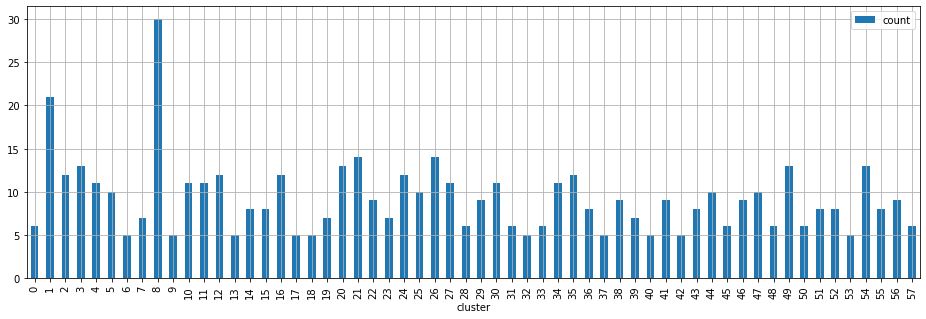

In [15]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [ ]:
def print_cluster_samples(n,ns=5,nt=100):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    top = [ t[:nt].replace('\n',' ') for t in data.query(f'cluster=={n}')['text'].sample(ns).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [16]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 49, элементов: 13, метки: "tech" ]

В России создадут ноутбук с защитой от морозов и ударов  Минпромторг выдал 150 миллионов рублей субс ...


Он будет востребован на производстве, в геологических экспедициях, в компаниях нефтегазового цикла   ...


Разработчик "Т-Платформы" утверждает, что ноутбук сохранит работоспособность после сильных ударов, в ...


Теги: Общество интернет компьютер технологии бизнес минпромторг  В России создадут противоударные и  ...


Разработкой сверхпрочных ноутбуков с защитой от воды, ударов, высоких (до +50 градусов) и низких (до ...


= = = = = = = = = = = = = = = = = = = = = = = = = =

[ КЛАСТЕР 47, элементов: 10, метки: "science" ]

Ученые пополнили список вымерших птиц 13 видами. Международный союз охраны природы добавил в Красную ...


Вчера, 19:16  Вымершие виды были добавлены Международным союзом охраны природы. Ранее они жили на ос ...


Вымершие пернатые обитали на островах  В Красную книгу были добавлены 740 новых видов птиц, из них 1 ..